<a href="https://colab.research.google.com/github/idieyidot/Python_Learning/blob/master/data_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:

import pandas as pd
import numpy as np
from google.colab import files


#upload excel sheet from laptop to google colab
uploaded = files.upload() 



Saving coronavirus_sequences_table.xlsx to coronavirus_sequences_table.xlsx


In [3]:
# read in all our data
dataset = pd.read_excel("coronavirus_sequences_table.xlsx")
# set seed for reproducibility
np.random.seed(0) 
dataset.sample(5)


,Details,Accession,Release_Date,Species,Genus,Family,Length,Genotype,Genome_Region,Segment,Authors,Publications,Geo_Location,Host,Isolation_Source,Collection_Date,BioSample,GenBank_Title
7057,NaN,DD451150,2007-07-02T00:00:00Z,Severe acute respiratory syndrome-related coro...,Betacoronavirus,Coronaviridae,182,NaN,NaN,NaN,"Vijeisuri,S., Getman,D.K., Linnen,J.M., Nelson...",NaN,NaN,NaN,NaN,NaN,NaN,Compositions and Methods for Determining the P...
3456,NaN,MH741316,2019-01-13T00:00:00Z,Betacoronavirus 1,Betacoronavirus,Coronaviridae,488,NaN,NaN,NaN,"He,Q.F., Guo,Z.J., Yue,H., Tang,C.",NaN,China,Bos grunniens,NaN,2015,NaN,Yak coronavirus isolate XZ8 S protein (S) gene...
7579,NaN,MG772864,2018-03-28T00:00:00Z,Severe acute respiratory syndrome-related coro...,Betacoronavirus,Coronaviridae,430,NaN,NaN,NaN,"Hu,D.",NaN,China,Rhinolophus sinicus,NaN,2016-01,NaN,Bat SARS-like coronavirus isolate bat-SL-CoVZ2...
4284,NaN,JN795147,2012-07-11T00:00:00Z,Betacoronavirus 1,Betacoronavirus,Coronaviridae,1038,NaN,NaN,NaN,"Bidokhti,M.R., Traven,M., Ohlson,A., Baule,C.,...",22750286,Sweden,Bos taurus,feces,2008,NaN,Bovine coronavirus isolate C5_0801 spike glypr...
6963,NaN,AF523850,2002-08-21T00:00:00Z,Betacoronavirus 1,Betacoronavirus,Coronaviridae,292,NaN,NaN,NaN,"Wu,H.Y., Guy,J.S., Yoo,D., Vlasak,R., Urbach,E...",14592769,NaN,NaN,NaN,NaN,NaN,"Equine Coronavirus NC99 3'UTR, partial sequence"


In [4]:

#check how many rows and columns
dataset.shape # (rows, column) respectively.

(7812, 18)

In [5]:
#to check the dimension number for our dataset
dataset.ndim

2

In [6]:
#Check datatypes of the column of our dataset
dataset.dtypes

Details             float64
Accession            object
Release_Date         object
Species              object
Genus                object
Family               object
Length                int64
Genotype             object
Genome_Region       float64
Segment             float64
Authors              object
Publications         object
Geo_Location         object
Host                 object
Isolation_Source     object
Collection_Date      object
BioSample            object
GenBank_Title        object
dtype: object

# 1. Dealing With Missing Values Generally (While doing Feature Selection)

In [7]:
# get the number of missing data points per column
missing_values_count = dataset.isnull().sum()

# look at the # of missing points of first 10 columns
missing_values_count[0:10]

Details          7812
Accession           0
Release_Date        0
Species             0
Genus               0
Family              0
Length              0
Genotype         7804
Genome_Region    7812
Segment          7812
dtype: int64

In [9]:
# how many total missing values do we have?
total_cells = np.product(dataset.shape)
total_missing = missing_values_count.sum()

# percent of data that is missing
(total_missing/total_cells) * 100


38.24671445639188

This is for removing all columns that has NAN (missing values)

In [10]:
# pandas drop columns using list of column names (selective drop)
new_dataset = dataset.drop(['Details', 'Genotype', 'Genome_Region','Segment','BioSample', 'Isolation_Source', 'Collection_Date','Publications','Geo_Location', 'Authors'], axis=1)



In [12]:
#saving the dropped column to a new csv file
new_dataset.to_csv("dropped_columns.csv", index=False, encoding ='utf8') 

In [13]:
#check back if it really dropped the column
missing_values_count = new_dataset.isnull().sum()

# look at the # of missing points
missing_values_count[0:18] #checked all column 

#from this, we can see that there's only 9 column left

Accession           0
Release_Date        0
Species             0
Genus               0
Family              0
Length              0
Host             2296
GenBank_Title       0
dtype: int64

In [14]:
# To confirm, let's compare the column number between previous dataset and new dataset
print("Columns in original dataset: %d \n" % dataset.shape[1])
print("Columns in new dataset: %d" % new_dataset.shape[1])

Columns in original dataset: 18 

Columns in new dataset: 8


Feature selection was done by dropping the column that contains missing values as it was not needed while solving the missing values problems. However, there's 1 more column that has missing values, I cannot delete this as it is a crucial information for the host prediction later. 



# 2. Dealing with missing values in Host Column

In [15]:
# replace all NA's with 0
new_dataset2=new_dataset.fillna('null')
new_dataset2.to_csv("no_missing_values.csv", index=False, encoding ='utf8') 

In [16]:
#check back if it really filled the missing values
missing_values_count = new_dataset2.isnull().sum()

# look at the # of missing points
missing_values_count[0:18] #checked all column 

#from this, we can see that there's no more missing values on the host column

Accession        0
Release_Date     0
Species          0
Genus            0
Family           0
Length           0
Host             0
GenBank_Title    0
dtype: int64

# 3. Detect Redundancy and Remove duplicated rows

To find whether a data-set contain duplicate rows or not we can use Pandas DataFrame.duplicated()  either for all columns or for some selected columns. pandas.Dataframe.duplicated() returns a Boolean series denoting duplicate rows

In [17]:
duplicate_rows_df = new_dataset2[new_dataset2.duplicated()]
print ("Number of duplicate rows: ", duplicate_rows_df.shape)

Number of duplicate rows:  (0, 8)


It is shown (row, column) respectively means 0 duplicated rows in 8 columns. 

# 4. Scaling and Normalization

In [42]:
# for Box-Cox Transformation
from scipy import stats

# for min_max scaling
from mlxtend.preprocessing import minmax_scaling

# plotting modules
import seaborn as sns
import matplotlib.pyplot as plt

#note that the current dataset name is : new_dataset2

dataset3=pd.read_csv("no_missing_values.csv")

# set seed for reproducibility
np.random.seed(0)

**Scaling**
This means that you're transforming your data so that it fits within a specific scale. Hence I will be scaling the length column for the coronavirus dataset

/usr/local/lib/python3.7/dist-packages/mlxtend/preprocessing/scaling.py:40: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ary_new = ary_new[:, np.newaxis]
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Scaled data')

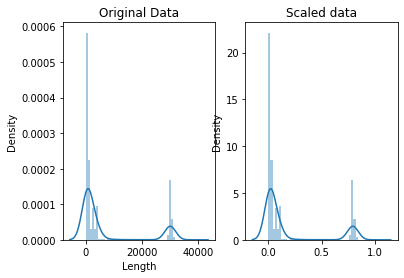

In [45]:
# generate 1000 data points randomly drawn from an exponential distribution
length_seq= dataset3.Length

# mix-max scale the data between 0 and 1
scaled_data = minmax_scaling(length_seq, columns = [0])

# plot both together to compare
fig, ax=plt.subplots(1,2)
sns.distplot(dataset3.Length, ax=ax[0])
ax[0].set_title("Original Data")
sns.distplot(scaled_data, ax=ax[1])
ax[1].set_title("Scaled data")

In [47]:
#figure out if we need to scale this or not and how to save in CSV

**Normalization** 
The point of normalization is to change your observations so that they can be described as a normal distribution.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Normalized data')

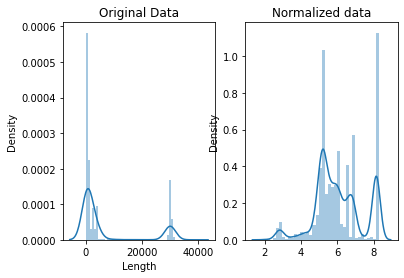

In [35]:

# get the index of all positive pledges (Box-Cox only takes postive values)
index_Length = dataset3.Length > 0

# get only positive pledges (using their indexes)
positive_Lengths = dataset3.Length.loc[index_Length]

# normalize the pledges (w/ Box-Cox)
normalized_Lengths = stats.boxcox(positive_Lengths)[0]

# plot both together to compare
fig, ax=plt.subplots(1,2)
sns.distplot(positive_Lengths, ax=ax[0])
ax[0].set_title("Original Data")
sns.distplot(normalized_Lengths, ax=ax[1])
ax[1].set_title("Normalized data")